# Graph Convolution Neural Networks

In [143]:
import numpy as np
from matplotlib import pyplot as plt
import librosa as lb

### Toy dataset: two sources

In [264]:
def Amp():
    return np.random.uniform(0.5, 2.5)

def freq():
    return np.random.randint(1, 10)

def func():
    return np.random.choice([np.sin, np.cos])

In [265]:
def generate_random_lambda():
    A = [[1, 0.1],
         [0.2, 1]]
    return np.array(A)

In [266]:
def generate_sources(n):
    S = []
    fs = 3200
    t = np.arange(0, 1, 1/fs)
    for i in range(n):
        s1 = Amp() * func()(2*np.pi*freq()*t) + Amp() * func()(2*np.pi*freq()*t)
        s2 = Amp() * func()(2*np.pi*freq()*t) + Amp() * func()(2*np.pi*freq()*t)
        S.append([s1, s2])
    return np.array(S)

In [267]:
S = generate_sources(1000)
A = generate_random_lambda()
X = A @ S

In [268]:
Ytest = generate_sources(20)
Xtest = A @ Ytest

In [269]:
Xtrain = X
Ytrain = S

### U-Net 

In [198]:
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Conv2DTranspose
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import layers
import tensorflow as tf

In [344]:
def double_conv_block(x, n_filters):
    leakyrelu = tf.keras.layers.LeakyReLU(alpha=0.3)
    x = layers.Conv2D(n_filters, (2, 2), padding = "same", activation = leakyrelu)(x)
    x = layers.Conv2D(n_filters, (2, 2), padding = "same", activation = leakyrelu)(x)

    return x

In [345]:
def downsample_block(x, n_filters):
    f = double_conv_block(x, n_filters)
    p = layers.MaxPool2D((1, 2))(f)
    p = layers.Dropout(0.3)(p)

    return f, p

In [346]:
def upsample_block(x, conv_features, n_filters):
    # upsample
    x = layers.Conv2DTranspose(n_filters, (2, 2), (1, 2), padding="same")(x)
    #print('UPSAMPLING')
    #print(x.shape)
    # concatenate 
    x = layers.concatenate([x, conv_features])
    # dropout
    x = layers.Dropout(0.3)(x)
    # Conv2D twice with ReLU activation
    x = double_conv_block(x, n_filters)

    return x

In [365]:
def build_unet_model():

    # inputs
    inputs = layers.Input(shape=(2, 3200, 1))

    # encoder: contracting path - downsample
    # 1 - downsample
    f1, p1 = downsample_block(inputs, 64)
    # 2 - downsample
    f2, p2 = downsample_block(p1, 128)
    # 3 - downsample
    f3, p3 = downsample_block(p2, 256)
    # 4 - downsample
    f4, p4 = downsample_block(p3, 512)

    # 5 - bottleneck
    bottleneck = double_conv_block(p4, 1024)
    

    # decoder: expanding path - upsample
    # 6 - upsample
    u6 = upsample_block(bottleneck, f4, 512)
    # 7 - upsample
    u7 = upsample_block(u6, f3, 256)
    # 8 - upsample
    u8 = upsample_block(u7, f2, 128)
    # 9 - upsample
    u9 = upsample_block(u8, f1, 64)

    # outputs
    outputs = layers.Conv2D(1, 1, padding="same", activation = "linear")(u9)
    #print(outputs.shape)

    # unet model with Keras Functional API
    unet_model = tf.keras.Model(inputs, outputs, name="U-Net")

    return unet_model

In [366]:
unet_model = build_unet_model()

In [367]:
#unet_model.summary()

In [368]:
unet_model.compile(optimizer=tf.keras.optimizers.Adam(),
                   loss="mse")

In [369]:
epochs = 3
model_history = unet_model.fit(Xtrain, Ytrain, epochs=epochs)

Epoch 1/3
32/32 [==============================] - 395s 12s/step - loss: 0.6805
Epoch 2/3
32/32 [==============================] - 416s 13s/step - loss: 0.0337
Epoch 3/3
32/32 [==============================] - 396s 12s/step - loss: 0.0198


In [370]:
loss = unet_model.evaluate(Xtest, Ytest)
print(loss)

1/1 [==============================] - 2s 2s/step - loss: 0.0040
0.004009800497442484


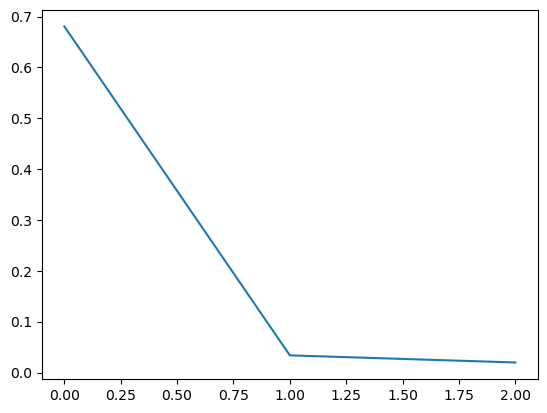

In [371]:
plt.plot(model_history.history['loss'])
plt.show()

In [372]:
predictions = unet_model.predict(Xtest)
predictions = np.squeeze(predictions)

1/1 [==============================] - 2s 2s/step


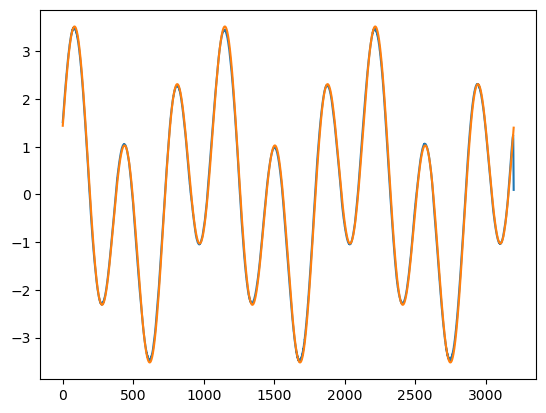

In [373]:
plt.plot(predictions[0][0])
#plt.plot(predictions[0][1])
plt.plot(Ytest[0][0])
#plt.plot(Ytest[0][1])
plt.show()

In [374]:
for layer in unet_model.layers:
    if 'conv' in layer.name:
        filters, biases = layer.get_weights()
        print(layer.name, filters.shape)

conv2d_142 (2, 2, 1, 64)
conv2d_143 (2, 2, 64, 64)
conv2d_144 (2, 2, 64, 128)
conv2d_145 (2, 2, 128, 128)
conv2d_146 (2, 2, 128, 256)
conv2d_147 (2, 2, 256, 256)
conv2d_148 (2, 2, 256, 512)
conv2d_149 (2, 2, 512, 512)
conv2d_150 (2, 2, 512, 1024)
conv2d_151 (2, 2, 1024, 1024)
conv2d_transpose_24 (2, 2, 512, 1024)
conv2d_152 (2, 2, 1024, 512)
conv2d_153 (2, 2, 512, 512)
conv2d_transpose_25 (2, 2, 256, 512)
conv2d_154 (2, 2, 512, 256)
conv2d_155 (2, 2, 256, 256)
conv2d_transpose_26 (2, 2, 128, 256)
conv2d_156 (2, 2, 256, 128)
conv2d_157 (2, 2, 128, 128)
conv2d_transpose_27 (2, 2, 64, 128)
conv2d_158 (2, 2, 128, 64)
conv2d_159 (2, 2, 64, 64)
conv2d_160 (1, 1, 64, 1)


In [357]:
def get_feature(layer_name, test):
    layer_outputs = [layer.output for layer in unet_model.layers if layer.name == layer_name]
    activation_model = Model(inputs=unet_model.input, outputs=layer_outputs)
    return activation_model.predict(test)

In [375]:
feature_map = get_feature('conv2d_160' , Xtest[:1, :, :])
feature_map = np.squeeze(feature_map)

1/1 [==============================] - 0s 213ms/step


In [376]:
feature_map.shape

(2, 3200)

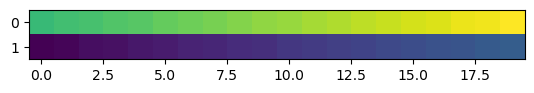

In [377]:
plt.imshow(feature_map[:, :20])
plt.show()

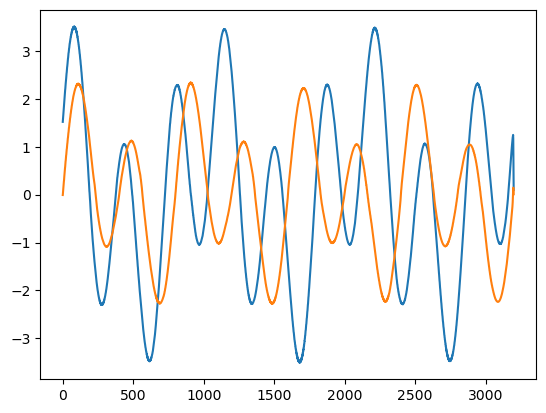

In [378]:
plt.plot(feature_map[0])
plt.plot(feature_map[1])
plt.show()